In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from affine import *

### Target log probability
Takes tensor of (n_walkers, n_parameters) input parameter vectors, return shape (n_walkers,) i.e., the log probability for each of the input parameter vectors

In [3]:
# target log probability
@tf.function
def log_prob(theta):
    
    # seperate out parameters
    x, y = tf.split(theta, (1,1), axis=-1)
    
    # rosenbrock function
    return -tf.squeeze(tf.divide(tf.square(1. - x) + tf.multiply(100., tf.square(y - tf.square(x))), 20.), -1)

### Initialize the walkers
You need to initialize *two* sets of "walkers", each of shape (n_walkers, n_parameters), for the parallel affine sampler. It's generally a good idea to initialize walkers in a tight-ish ball close to some fiducial parameter guess (and the sampler will burn in from there). The two sets of walkers (put into a list) define the initial "current state" for the sampler.

In [4]:
# number of parameters
n_params = 2

# number of walkers (note you'll end up with a total of 2*n_walkers for this parallel variant of the affine sampler)
n_walkers = 500

# initialize walkers and current state
walkers1 = tf.random.normal([n_walkers, n_params], 0., 1.)
walkers2 = tf.random.normal([n_walkers, n_params], 0., 1.)
current_state = [walkers1, walkers2]

### Run the sampler!

In [5]:
# number of MCMC steps to take (you'll end up with an MCMC chain with shape (n_steps, 2*n_walkers, n_parameters))
n_steps = 300

# run the sampler
chain = affine_sample(log_prob, n_steps, current_state, args=[])

100%|██████████| 299/299 [00:00<00:00, 448.83it/s]


### Plot the results

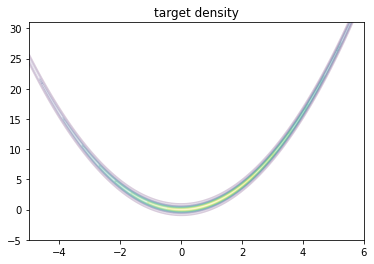

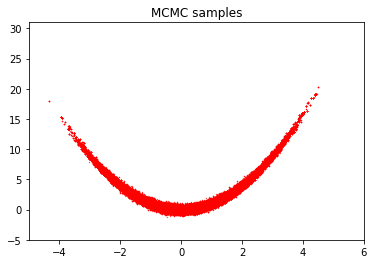

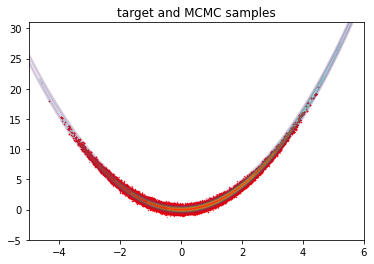

In [6]:
# plot the results...

# how many burnin steps to remove
burnin_steps = 100

# plot the target density
x = np.linspace(-5, 6, 500).astype(np.float32)
y = np.linspace(-5, 31, 500).astype(np.float32)
X, Y = np.meshgrid(x, y)
grid = tf.stack([X, Y], axis=-1)
L = tf.exp(log_prob(grid)).numpy()
plt.contour(x, y, L, levels = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])*np.max(L.flatten()).astype(np.float64), alpha = 0.2)
plt.title('target density')
plt.show()

# scatter
plt.title('MCMC samples')
plt.scatter(chain.numpy()[burnin_steps:,:,0], chain.numpy()[burnin_steps:,:,1], s = 0.1, color = 'red')
plt.xlim(-5, 6)
plt.ylim(-5, 31)
plt.show()

# scatter + contours of target prob
plt.title('target and MCMC samples')
x = np.linspace(-5, 6, 500).astype(np.float32)
y = np.linspace(-5, 31, 500).astype(np.float32)
X, Y = np.meshgrid(x, y)
grid = tf.stack([X, Y], axis=-1)
L = tf.exp(log_prob(grid)).numpy()
plt.contour(x, y, L, levels = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])*np.max(L.flatten()).astype(np.float64), alpha = 0.2)
plt.scatter(chain.numpy()[burnin_steps:,:,0], chain.numpy()[burnin_steps:,:,1], s = 0.05, color = 'red')
plt.show()